In [263]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import statsmodels.formula.api as sm

In [197]:
AAPL = pickle.load(open("AAPL", "rb"))
C = pickle.load(open("C", "rb"))
GBX = pickle.load(open("GBX", "rb"))
SPY = pickle.load(open("SPY", "rb"))
THO = pickle.load(open("THO", "rb"))

In [369]:
class Orderbook:
    
    def __init__(self, orderbook):
        self.timestamp = orderbook[0]
        orderbook = pd.DataFrame.from_dict(orderbook[1], orient='index')
        orderbook.drop(columns=[2, 3], inplace=True)
        orderbook.reset_index(inplace=True)
        orderbook.columns = ['price', 'quantity', 'side']
        orderbook.sort_values('price', inplace=True)
        buy = orderbook[orderbook.side == 'B'].sort_values('price', ascending=False)
        buy['y'] = -buy['quantity'].cumsum()
        
        sell = orderbook[orderbook.side == 'S'].sort_values('price', ascending=True)
        sell['y'] = sell['quantity'].cumsum()
        
        orderbook = pd.concat([buy, sell])
        orderbook.sort_values('price', inplace=True)
        self.orderbook = orderbook
        self.orderbook98 = orderbook[(orderbook.price <= orderbook.price.quantile(0.99)) 
                               & (orderbook.price >= orderbook.price.quantile(0.01))]
        
        self.orderbook50 = orderbook[(orderbook.price <= sell.price.median()) 
                               & (orderbook.price >= buy.price.median())]

    def plot(self):
        orderbook98 = self.orderbook98
        plt.plot(orderbook98.price, orderbook98.y, label='Orderbook')

    def OLS(self, orderbook):
        result = sm.ols(formula="y ~ price", data=orderbook).fit()
        return result.params
    
    def plot_estimates(self):
        orderbook50 = self.orderbook50
        orderbook98 = self.orderbook98
        ols_params = self.OLS(orderbook50)
        γ = ols_params[0]
        β = ols_params[1]
        est = γ + β * orderbook98.price
        plt.plot(orderbook98.price, est, label='Estimate')
        plt.xlim(orderbook98.price.min(), orderbook98.price.max())
        plt.ylim(orderbook98.y.min() * 1.1, orderbook98.y.max() * 1.1)
        
    def find_p0(self):
        orderbook = self.orderbook
        best_offer = orderbook[orderbook.side == 'S'].price.min()
        best_bid = orderbook[orderbook.side == 'B'].price.max()
        return (best_offer + best_bid) / 2

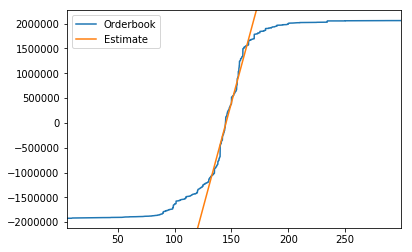

In [384]:
o = Orderbook(AAPL[0])
o.plot()
o.plot_estimates()
plt.legend()
plt.show()

In [378]:
class Ticker:
    
    def __init__(self, orderbooks):
        self.orderbooks = [Orderbook(orderbook) for orderbook in orderbooks]
        self.timestamps = [orderbook.timestamp for orderbook in self.orderbooks]
        
    def estimate_β(self):
        orderbooks = self.orderbooks
        β = np.array([orderbook.OLS(orderbook.orderbook50)[1] for orderbook in orderbooks])
        return β
    
    def estimate_γ(self):
        orderbooks = self.orderbooks
        γ = np.array([orderbook.OLS(orderbook.orderbook50)[0] for orderbook in orderbooks])
        return γ
    
    def plot_β(self):
        β = self.estimate_β()
        plt.plot(self.timestamps, β)
        
    def plot_p0_estimate(self):
        β = self.estimate_β()
        γ = self.estimate_γ()
        p0 = - γ / β
        plt.plot(self.timestamps, p0)
    
    def plot_p0(self):
        orderbooks = self.orderbooks
        p0 = np.array([orderbook.find_p0() for orderbook in orderbooks])
        plt.plot(self.timestamps, p0)
        

In [379]:
aapl = Ticker(AAPL)
# c = Ticker(C)
# gbx = Ticker(GBX)
# spy = Ticker(SPY)
# tho = Ticker(THO)

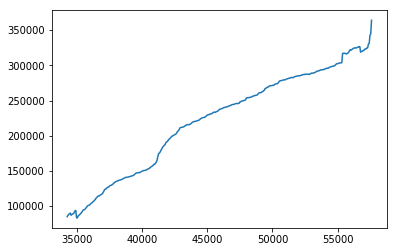

In [360]:
aapl.plot_β()

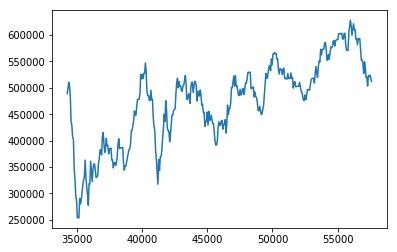

In [361]:
c.plot_β()

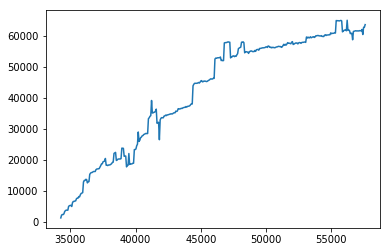

In [362]:
gbx.plot_β()

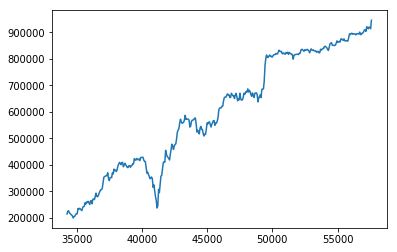

In [363]:
spy.plot_β()

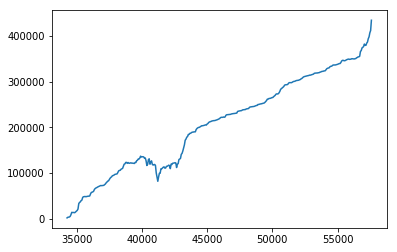

In [364]:
tho.plot_β()

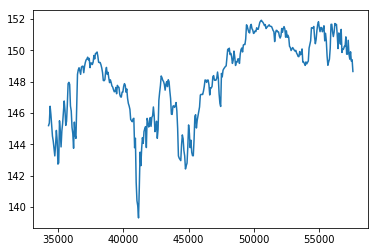

In [380]:
aapl.plot_p0_estimate()

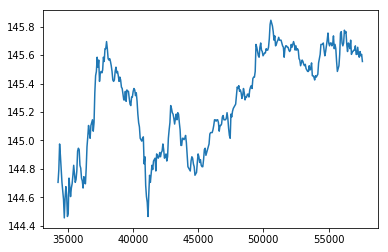

In [381]:
aapl.plot_p0()